Stajesz przed nowym zadaniem, nowy product manager poprosił Cię o pomoc w obliczeniu i wizualizacji nowego KPI, który ma
pomóc ulepszyć proces dostarczania rezultatów do klienta. Jego definicja to: Ilość zaakceptowanych błędów na godzinę w 
pierwszych 6-ciu godzinach od rozpoczęcia cyklu testowego. PM przekazał Ci, że dla uproszczenia jako początek cyklu testowego możesz uznać czas pierwszego zgłoszonego błędu. 

Jeżeli uda Ci się pokazać tą metrykę, PM napewno doceni analizę na tych danych - ponieważ on nie ma na to czasu.

Stwórz widok pokazujący powyższą metryke i zaproponuj dodatkowe wykresy z które mogą być przydatne dla Product Manager'a.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
data = pd.read_csv('cycle_data.csv')

In [3]:
data.sample(10)

,issue_code_,created_at,severity,resolution,affected_components,creator_id
61,CYCLE-10-62,13/04/2021 16:45:50,Medium,Confirmed (S),{Workouts},6435.0
80,CYCLE-10-81,13/04/2021 18:46:09,Medium,No tester response,{Profile},6435.0
64,CYCLE-10-65,13/04/2021 17:01:19,Medium,Confirmed (S),{Profile},5271.0
73,CYCLE-10-74,13/04/2021 17:28:46,High,Confirmed (S),{Profile},8124.0
38,CYCLE-10-39,13/04/2021 16:17:27,Medium,Confirmed (S),{Workouts},4075.0
98,CYCLE-10-99,13/04/2021 21:59:34,Medium,Confirm (S),{Workouts},5271.0
91,CYCLE-10-92,13/04/2021 20:47:27,Low,Confirmed (S),{Profile},6435.0
23,CYCLE-10-24,13/04/2021 16:00:55,High,Confirmed (S),{Workouts},5589.0
46,CYCLE-10-47,13/04/2021 16:26:02,Critical,Confirmed (S),{Workouts},5271.0
72,CYCLE-10-73,13/04/2021 17:16:32,Low,Not in Scope,{Profile},1765.0


In [4]:
data.severity.unique()

array(['Low', 'High', 'Medium', 'Critical'], dtype=object)

In [5]:
data.resolution.unique()

array(['Confirmed (S)', 'Duplicate', 'Expected Behaviour',
       'Confirmed (!)', 'Invalid - not tester error', 'Not in Scope',
       'No tester response', 'Confirm (S)'], dtype=object)

In [6]:
data.affected_components.unique()

array(['{Signup}', '{Profile}', 'Profile', '{Sign-up}', '{Content}',
       '{Challenge}', '{Workouts}', '{Settings}', '{Kit}', '{Guides}',
       '{Meals}', '{Login}'], dtype=object)

In [7]:
# First step will be to clear the data.
# I replace rows where resolution status is 'Confirmed (!)' and 'Confirm (S)' with status 'Confirmed (S)', because it's 
# the same category 

data["resolution"].replace({"Confirmed (!)": "Confirmed (S)", "Confirm (S)": "Confirmed (S)"}, inplace=True)
data.resolution.unique()

array(['Confirmed (S)', 'Duplicate', 'Expected Behaviour',
       'Invalid - not tester error', 'Not in Scope', 'No tester response'],
      dtype=object)

In [8]:
data.isnull().sum()

issue_code_            0
created_at             1
severity               0
resolution             0
affected_components    0
creator_id             1
dtype: int64

In [9]:
# Drop rows where NaN is in 'created_at' column, because we need this data to check if error was created within first 
# 6 hours of testing cycle.

data.dropna(subset=['created_at'], inplace=True)
data['created_at'].isnull().sum()

0

In [10]:
type(data['created_at'][0])

str

In [11]:
# I want to change data type in column "created_at" to datetime 
# There is an error appearing because of wrong format in one row, so I'm going to change this

data[data['created_at'] == '04/13/2021 16:25:40']

,issue_code_,created_at,severity,resolution,affected_components,creator_id
44,CYCLE-10-45,04/13/2021 16:25:40,High,Confirmed (S),{Workouts},4693.0


In [12]:
data.at[44, 'created_at'] = '13/04/2021 16:25:40'
data.loc[44, 'created_at']

'13/04/2021 16:25:40'

In [13]:
# Change format 
data['created_at'] = pd.to_datetime(data['created_at'], format='%d/%m/%Y %H:%M:%S')

In [14]:
type(data['created_at'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [15]:
# Now I'm going to create a new column 'cycle_hour' with information about hour of testing cycle (from 1 to 6) in which error appeared
start_date = data.loc[0, 'created_at']
end_date = start_date + pd.DateOffset(hours=1)
start_date, end_date

(Timestamp('2021-04-13 15:35:36'), Timestamp('2021-04-13 16:35:36'))

In [16]:
for i in range(6):
    data.loc[(data['created_at'] >= start_date + pd.DateOffset(hours=i)) & (data['created_at'] < end_date + pd.DateOffset(hours=i)), 'cycle_hour'] = i+1

In [17]:
# Drop rows if issue appeared after 6 hours.
data.dropna(subset=['cycle_hour'], inplace=True)
data['cycle_hour'].isnull().sum()

0

In [18]:
data.sample(5)

,issue_code_,created_at,severity,resolution,affected_components,creator_id,cycle_hour
55,CYCLE-10-55,2021-04-13 16:38:39,High,Confirmed (S),{Kit},4693.0,2.0
62,CYCLE-10-63,2021-04-13 16:46:16,High,Confirmed (S),{Workouts},4075.0,2.0
60,CYCLE-10-61,2021-04-13 16:45:38,Medium,Confirmed (S),{Meals},3230.0,2.0
66,CYCLE-10-67,2021-04-13 17:02:25,High,Confirmed (S),{Meals},8124.0,2.0
48,CYCLE-10-49,2021-04-13 16:28:58,Low,Confirmed (S),{Guides},1066.0,1.0


In [19]:
confirmed_data = data[data['resolution'] == 'Confirmed (S)']

In [20]:
confirmed_data['cycle_hour'].unique()

array([1., 2., 3., 4., 5., 6.])

In [21]:
confirmed_by_hours = (
    confirmed_data
    .groupby(['cycle_hour'])
    ['issue_code_'].count()
    .reset_index()
    .rename(columns={'issue_code_': 'number_of_issues'})
    
)

confirmed_by_hours

,cycle_hour,number_of_issues
0,1.0,47
1,2.0,16
2,3.0,4
3,4.0,5
4,5.0,2
5,6.0,5


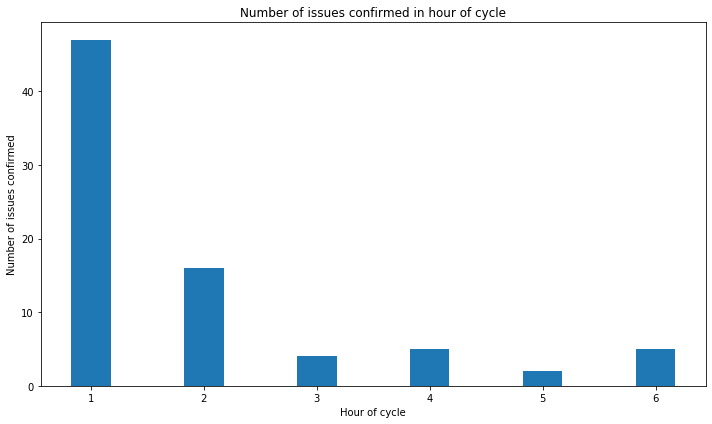

In [22]:
# Plot1: number of issues in 6 hours after starting the testing cycle 
# We can see that most issues were confirmed in first hour of cycle.

plt.figure(figsize=(10,6))
plt.bar(confirmed_by_hours.cycle_hour, confirmed_by_hours.number_of_issues, width=0.35, align='center')
plt.xlabel('Hour of cycle')
plt.ylabel('Number of issues confirmed')
plt.title('Number of issues confirmed in hour of cycle')
plt.savefig('Issues per hour.pdf')
plt.tight_layout()
plt.show()

In [23]:
severity_data = confirmed_data
severity_data = severity_data.reset_index().groupby(['cycle_hour', 'severity'])['issue_code_'].aggregate('count').unstack()
severity_data.fillna(0.0, inplace=True)
severity_data

severity,Critical,High,Low,Medium
cycle_hour,,,,
1.0,3.0,12.0,17.0,15.0
2.0,1.0,5.0,3.0,7.0
3.0,0.0,2.0,1.0,1.0
4.0,0.0,2.0,1.0,2.0
5.0,0.0,0.0,0.0,2.0
6.0,0.0,1.0,1.0,3.0


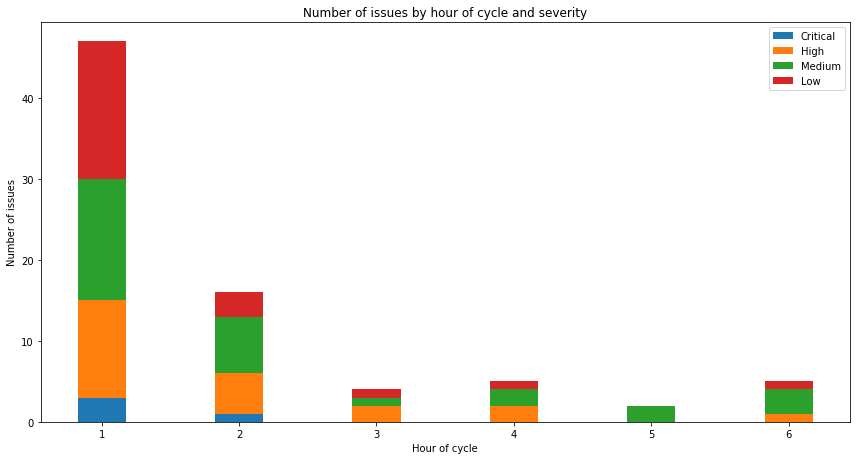

In [31]:
# Plot2: number of issues in 6 hours after starting the testing cycle by severities
# From this chart we can see that critical issues was confirmed fast, in first 2 hours of cycle.

critical = np.array(severity_data['Critical'])
high = np.array(severity_data['High'])
medium = np.array(severity_data['Medium'])
low = np.array(severity_data['Low'])

x = np.arange(6)    
width = 0.35       

fig, ax = plt.subplots()
fig.set_size_inches(12, 6.5)

p1 = ax.bar(x, critical, width, label='Critical')
p2 = ax.bar(x, high, width,bottom= critical, label='High')
p3 = ax.bar(x, medium, width,bottom= critical + high, label='Medium')
p4 = ax.bar(x, low, width, bottom= critical+ high + medium,
             label='Low')


ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Number of issues')
ax.set_xlabel('Hour of cycle')
ax.set_title('Number of issues by hour of cycle and severity')
ax.set_xticks(x)
ax.set_xticklabels(['1', '2', '3', '4', '5', '6'])
ax.legend()

plt.tight_layout()
plt.savefig('Issues by hour of cycle and severity.pdf')
plt.show()

In [25]:
# Plot 3: number of issues by affected components
# Preparing data

confirmed_data['affected_components'].unique()

array(['{Signup}', '{Profile}', 'Profile', '{Content}', '{Challenge}',
       '{Workouts}', '{Kit}', '{Guides}', '{Meals}', '{Settings}',
       '{Login}'], dtype=object)

In [33]:
confirmed_data['affected_components'].replace({'Profile': '{Profile}'}, inplace=True)
confirmed_data['affected_components'].unique()

array(['{Signup}', '{Profile}', '{Content}', '{Challenge}', '{Workouts}',
       '{Kit}', '{Guides}', '{Meals}', '{Settings}', '{Login}'],
      dtype=object)

In [27]:
affected_components = (
    confirmed_data
    .groupby(['affected_components'])
    ['issue_code_'].count()
    .reset_index()
    .rename(columns={'issue_code_': 'number_of_issues', 'affected_components': 'components'})
    .sort_values(by='number_of_issues', ascending=False)
)
affected_components

,components,number_of_issues
6,{Profile},22
9,{Workouts},19
8,{Signup},14
1,{Content},7
3,{Kit},5
0,{Challenge},4
2,{Guides},3
5,{Meals},3
4,{Login},1
7,{Settings},1


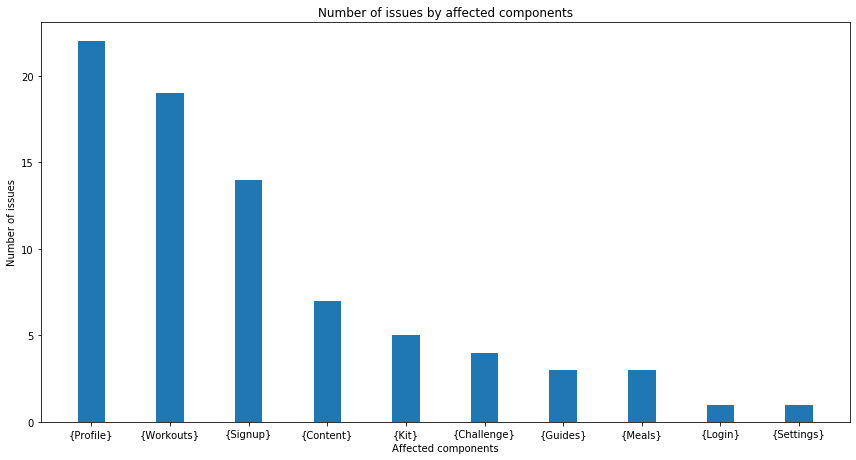

In [28]:
# Creating plot
# We can see which components was affected by significant amount of issues. This can indicate the parts of project to work on.

plt.figure(figsize=(12,6.5))
plt.bar(affected_components.components, affected_components.number_of_issues, width=0.35, align='center')
plt.xlabel('Affected components')
plt.ylabel('Number of issues')
plt.title('Number of issues by affected components')
plt.savefig('Number of issues by affected components.pdf')
plt.tight_layout()
plt.show()

In [29]:
# Prepare dataframe to show number of issues by affected components and severity
severity_components = confirmed_data
severity_components = severity_components.reset_index().groupby(['affected_components', 'severity'])['issue_code_'].aggregate('count').unstack()
severity_components.fillna(0.0, inplace=True)
severity_components.head()

severity,Critical,High,Low,Medium
affected_components,,,,
{Challenge},0.0,1.0,0.0,3.0
{Content},0.0,3.0,2.0,2.0
{Guides},0.0,0.0,3.0,0.0
{Kit},0.0,2.0,2.0,1.0
{Login},0.0,1.0,0.0,0.0


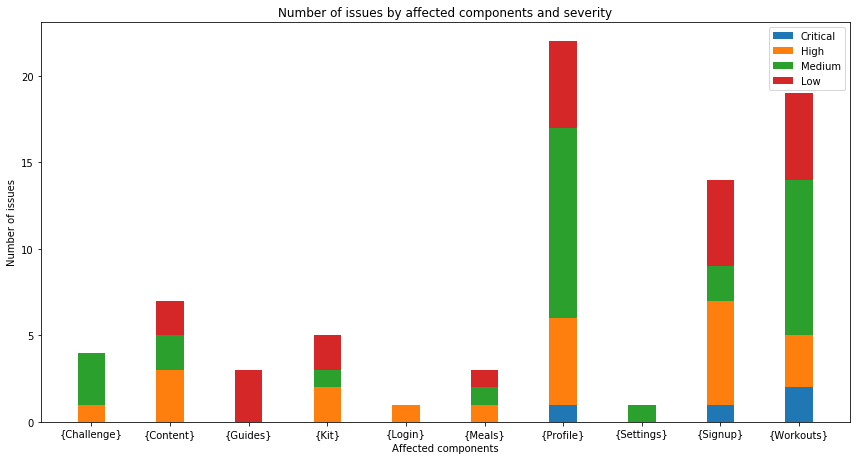

In [30]:
# Plot 4: number of issues by affected components and severity of issues
# From this chart we can see which components are most vulnerable- affected by critical and high errors. This can help deciding 
# where to start working on project- which components are most important.

critical = np.array(severity_components['Critical'])
high = np.array(severity_components['High'])
medium = np.array(severity_components['Medium'])
low = np.array(severity_components['Low'])

x = np.arange(10)    
width = 0.35       

fig, ax = plt.subplots()
fig.set_size_inches(12, 6.5)

p1 = ax.bar(x, critical, width, label='Critical')
p2 = ax.bar(x, high, width,bottom= critical, label='High')
p3 = ax.bar(x, medium, width,bottom= critical + high, label='Medium')
p4 = ax.bar(x, low, width, bottom= critical+ high + medium,
             label='Low')


ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Number of issues')
ax.set_xlabel('Affected components')
ax.set_title('Number of issues by affected components and severity')
ax.set_xticks(x)
ax.set_xticklabels(severity_components.index)
ax.legend()

plt.tight_layout()
plt.savefig('Issues by affected components and severity.pdf')
plt.show()